In [193]:
import numpy as np
import pygmo as pg
import pykep as pk
import matplotlib.pyplot as plt

In [194]:

################
### Constants
################

# Start and end epochs
T_START = pk.epoch_from_iso_string("30190302T000000")
T_END = pk.epoch_from_iso_string("30240302T000000")

# Cavendish constant (m^3/s^2/kg)
G = 6.67430e-11

# Sun_mass (kg)
SM = 1.989e30

# Mass and Mu of the Trappist-1 star
MS = 8.98266512e-2 * SM
MU_TRAPPIST = G * MS

# DV per propellant [m/s]
DV_per_propellant = 10000

# Maximum time to fully mine an asteroid
TIME_TO_MINE_FULLY = 30

# Loading the asteroid data
data = np.loadtxt("candidates.txt")
asteroids = []
for line in data:
    p = pk.planet.keplerian(
        T_START,
        (
            line[1],
            line[2],
            line[3],
            line[4],
            line[5],
            line[6],
        ),
        MU_TRAPPIST,
        G * line[7],  # mass in planet is not used in UDP, instead separate array below
        1,  # these variable are not relevant for this problem
        1.1,  # these variable are not relevant for this problem
        "Asteroid " + str(int(line[0])),
    )
    asteroids.append(p)



# And asteroids' masses and material type
asteroid_masses = data[:, -2]
asteroid_materials = data[:, -1].astype(int)

astID_mat0 = []
astID_mat1 = []
astID_mat2 = []
astID_mat3 = []
astID_All = []

for i in range(0,10000):
    astID_All.append(i)
    if asteroid_materials[i]==0:
        astID_mat0.append(i)
    if asteroid_materials[i]==1:
        astID_mat1.append(i)
    if asteroid_materials[i]==2:
        astID_mat2.append(i)
    if asteroid_materials[i]==3:
        astID_mat3.append(i) 

def llambert(sid,nid,tp,ta, tof, p):
        r1, v1 = asteroids[sid].eph(T_START.mjd2000 + tp)
        r2, v2 = asteroids[nid].eph(T_START.mjd2000 + ta)
        l = pk.lambert_problem(r1=r1, r2=r2, tof=tof * pk.DAY2SEC, mu=MU_TRAPPIST, cw=False, max_revs=0)
        DV1 = [a - b for a, b in zip(v1, l.get_v1()[0])]
        DV2 = [a - b for a, b in zip(v2, l.get_v2()[0])]
        DV = np.linalg.norm(DV1) + np.linalg.norm(DV2)
        p = p - DV / DV_per_propellant
        return p 

def filterM(ll,masse):
        rr = []
        for i in range(0,len(ll)):
            if(asteroid_masses[ll[i]] >= masse):
                rr.append(ll[i])
        return rr  
    

In [195]:
class astroProblem():
    def __init__(self,sid,m0,m1,m2,m3,tof):
        self.m0 = m0
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.tof = tof
        self.sid = sid
        self.ast_l = asteroids
        self.ast_m = asteroid_masses
        self.ast_types = asteroid_materials
        self.mat_l =[0,0,0,1.0]
        self.MU = MU_TRAPPIST
        self.ast_v = list()
        self.ast_v.append(sid)
        self.ta_l = [0]*100 
        self.tm_l = [0]*100
        self.ast0 = filterM(astID_mat0,m0)
        self.ast1 = filterM(astID_mat1,m1)
        self.ast2 = filterM(astID_mat2,m2)
        self.ast3 = filterM(astID_mat3,m3)
        self.astID_All = self.ast0+self.ast1+self.ast2
        
        
    def calcRoute(self,ast_v,ast_l, tp, ta,tof,p):
        p_l = []
        ast_n = []
        for i in range(0,len(ast_l)):
            if not ast_l[i] in ast_v :
                pnew = llambert(ast_v[-1],ast_l[i],tp,ta,tof,p)
                if(pnew > 0):
                            p_l.append(pnew)
                            ast_n.append(ast_l[i])
        if(len(p_l) > 0):
            zipped_l = zip(p_l,ast_n)
            sorted_l = sorted(zipped_l,key= lambda x: x[0])
            sorted_l = list(zip(*sorted_l))
            p_l = list(sorted_l[0])
            ast_n = list(sorted_l[1])
        return [p_l,ast_n]
    
        
    
       
    
    
    
    def NNb(self):
        ta_l = self.ta_l
        tm_l = self.tm_l
        mat_l = self.mat_l
        ast_types = self.ast_types
        ast_v = self.ast_v
        astID_All = self.astID_All
        calcRoute = self.calcRoute
        tof = self.tof
        ast_m = self.ast_m
        for i in range(1,len(ta_l)):
            fmin = 0.5
            tp = ta_l[i-1]+tm_l[i-1]
            ta_l[i]= tp+tof
            p_l, ast_n = calcRoute(ast_v,astID_All,tp,ta_l[i],tof,mat_l[3])   
            if len(p_l)==0:break
            p1 = p_l[-1]
            a1 = ast_n[-1]
            while(len(p_l) > 0):
                pp = p_l.pop()
                aa = ast_n.pop()
                       
                if mat_l[3] <=fmin:
                    p_l, ast_n = calcRoute(ast_v,self.ast3,tp,ta_l[i],tof,mat_l[3])
                    if len(p_l) == 0:
                        break
                    pp = p_l.pop()
                    aa = ast_n.pop()
                    tm_l[i]=ast_m[aa]*TIME_TO_MINE_FULLY
                    mat_l[3] = pp +ast_m[aa]
                    if mat_l[3] >= 1: mat_l[3] = 1
                    ast_v.append(aa)
                    break
 
                if(mat_l[3]>fmin):
                        
                    if(ast_types[aa] == 1 ):
                            mat_l[3] = pp
                            tm_l[i]=ast_m[aa]*TIME_TO_MINE_FULLY
                            mat_l[1]+= ast_m[aa]
                            ast_v.append(aa)
                            break
                    
                    if(ast_types[aa] == 0 and np.min(mat_l[:3]) == mat_l[0]):
                            mat_l[3] = pp
                            tm_l[i]=ast_m[aa]*TIME_TO_MINE_FULLY
                            mat_l[0]+= ast_m[aa]
                            ast_v.append(aa)
                            break
                        
                    if(ast_types[aa] == 2 and np.min(mat_l[:3])== mat_l[2]):
                            mat_l[3] = pp
                            tm_l[i]=ast_m[aa]*TIME_TO_MINE_FULLY
                            mat_l[2]+= ast_m[aa]
                            ast_v.append(aa)
                            break
                    if(len(p_l)==0):
                            mat_l[3] = p1
                            tm_l[i]=ast_m[aa]*TIME_TO_MINE_FULLY
                            mat_l[asteroid_materials[aa]]+= ast_m[aa]
                            ast_v.append(a1)
                            break 
            #print("fuel = ",self.matList[3],"|| Asteroid = ",aa, "|| Material = ",self.matList[:3])                
                    
            if len(p_l)==0 or mat_l[3] <= 0 or ta_l[i]+tm_l[i] >= 1827:
                    break
    
        n = len(ast_v)
        x = ta_l[:n]+tm_l[:n]+ ast_v         
        return [ast_v,mat_l[:3],x]
                 
            
            
               

In [196]:



m0 = 0.9
m1 = 0.7
m2 = 0.9
m3 = 0.5
tof = 18
ast0 = filterM(astID_mat0,m0)
ast1 = filterM(astID_mat1,m1)
ast2 = filterM(astID_mat2,m2)
ast3 = filterM(astID_mat3,m3)

print("m0 = ",len(ast0),"|m1 = ",len(ast1),"|m2 = ",len(ast2),"|m3 = ",len(ast3))

m0 =  457 |m1 =  97 |m2 =  506 |m3 =  530


In [197]:
J = []
D = []
a = []
b = []
c = []
u = 20
x = []
while u <= 30:
    minNorm = 0
    matl = []
    asst = []
   
    for i in range(0,10000,50):
        #rr = np.random.randint(0,10000)
        prob = astroProblem(i,m0,m1,m2,m3,u)
        nn,mm,zz = prob.NNb()
        if minNorm <=np.min(mm):
            minNorm = np.min(mm)
            matl = mm
            asst = nn
            x = zz
        print("Schleife i = ",i,"|| tof = ",u,"\n mat = ",mm,"||",matl)
        
    #print(x)        
    #print(asst)
    #print(matl)
    a.append(matl[0])
    b.append(matl[1])
    c.append(matl[2])
    D.append(u)
    u += 0.5


Schleife i =  0 || tof =  20 
 mat =  [0.9020043815143143, 0.9752652573664468, 0.9713113263974531] || [0.9020043815143143, 0.9752652573664468, 0.9713113263974531]
Schleife i =  50 || tof =  20 
 mat =  [1.9621517780137978, 0, 0.9161971475817375] || [0.9020043815143143, 0.9752652573664468, 0.9713113263974531]
Schleife i =  100 || tof =  20 
 mat =  [0.9357264626969639, 0.8726435450813458, 0.9610318366414868] || [0.9020043815143143, 0.9752652573664468, 0.9713113263974531]
Schleife i =  150 || tof =  20 
 mat =  [0.9391883567501932, 0.7540429460269872, 0.9808733079322759] || [0.9020043815143143, 0.9752652573664468, 0.9713113263974531]
Schleife i =  200 || tof =  20 
 mat =  [0.9852936527538168, 1.6597622051906398, 0] || [0.9020043815143143, 0.9752652573664468, 0.9713113263974531]
Schleife i =  250 || tof =  20 
 mat =  [0.9237743248465309, 0.886131476972293, 0.9070372068594124] || [0.9020043815143143, 0.9752652573664468, 0.9713113263974531]
Schleife i =  300 || tof =  20 
 mat =  [0, 0, 1

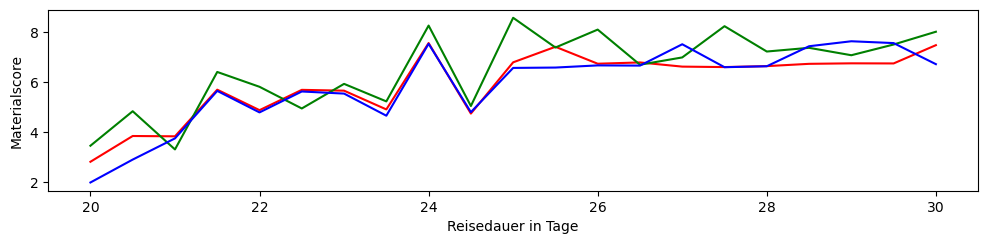

i =  0 || 2.7996188371560247 3.442714483575621 1.9695359649301212
i =  1 || 3.832645554257236 4.8256241427678335 2.8877205536719424
i =  2 || 3.820156486248064 3.2945295792236284 3.737027873143294
i =  3 || 5.689047287126575 6.399642855298924 5.640744292632309
i =  4 || 4.868419776877995 5.804871963935801 4.7785002545828155
i =  5 || 5.682465475058342 4.936155888034029 5.6169535138583475
i =  6 || 5.649771947146569 5.922326032423694 5.532703528885069
i =  7 || 4.898257025784808 5.219969609379739 4.646681610509393
i =  8 || 7.558355404841165 8.258942243612498 7.5293219610177315
i =  9 || 4.73235028280724 5.035354777737286 4.788168818327301
i =  10 || 6.7859767358631276 8.571242375193933 6.561659071445932
i =  11 || 7.408535902976259 7.379514947287716 6.576103572647518
i =  12 || 6.730087803476993 8.097665950313733 6.662708742877739
i =  13 || 6.7809238655994895 6.689622386895361 6.65462796783417
i =  14 || 6.613748458453199 6.98216284463938 7.509969798425486
i =  15 || 6.595393338370949

In [198]:

J = [a,b,c]
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(D,J[0],"red")
plt.subplot(3,1,1)
plt.plot(D,J[1],"green")
plt.subplot(3,1,1)
plt.plot(D,J[2],"blue")

plt.xlabel("Reisedauer in Tage")
plt.ylabel("Materialscore")
plt.show()
for i in range(0,len(J[0]),1):
 print("i = ",i, "||", J[0][i],J[1][i],J[2][i])

In [199]:
from esa_evaluation import udp
udp.fitness(x,True)

ID	t0	Propellant 	DV 	  Material ID	 Prepared 	 	Score
4433	30.00	0.89          	1085.44 	1	 0.00|0.77|0.00		0.00
8317	83.13	0.71          	1778.82 	0	 0.94|0.77|0.00		0.00
4397	141.39	0.60          	1151.66 	1	 0.94|1.51|0.00		0.00
6941	193.47	0.50          	956.31  	2	 0.94|1.51|0.98		0.94
6321	252.94	0.31          	1964.15 	0	 1.86|1.51|0.98		0.98
5143	310.41	0.99          	2056.34 	3	 1.86|1.51|0.98		0.98
2023	367.22	0.77          	2219.91 	2	 1.86|1.51|1.89		1.51
831	424.40	0.47          	3000.16 	1	 1.86|2.42|1.89		1.86
332	481.69	1.00          	1231.98 	3	 1.86|2.42|1.89		1.86
2507	534.05	0.95          	526.85  	0	 2.85|2.42|1.89		1.89
4449	593.89	0.58          	3713.78 	2	 2.85|2.42|2.87		2.42
3068	653.37	0.32          	2539.34 	1	 2.85|3.12|2.87		2.85
740	704.46	1.00          	2265.55 	3	 2.85|3.12|2.87		2.85
2874	762.69	0.89          	1121.05 	0	 3.78|3.12|2.87		2.87
6558	820.40	0.66          	2310.17 	1	 3.78|3.92|2.87		2.87
6391	874.47	0.40          	2526.45 	2	 3.78|3.92|3

[-6.712149415850774,
 0,
 0,
 -30.0,
 -30.0,
 -29.999999999999986,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -29.999999999999943,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.000000000000114,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0,
 -30.0]

In [200]:
from submission_helper import create_submission
from esa_evaluation import convert_to_chromosome
x = convert_to_chromosome(x)
create_submission("spoc-mining","mine-the-belt",x,"submission_file.json","TUDa_spaceX","submission_description")